In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import os
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
from collections import Counter

In [2]:
uru = gpd.read_file("ury_adm_2020_shp.zip")

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'ury_adm_2020_shp.zip': 'ury_admbnda_adm0_2020' (default), 'ury_admbnda_adm1_2020', 'ury_admbnda_adm2_2020', 'ury_admbndl_ALL_2020'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
def means_plot(folder, month, year, variable=None, model_name=None, scenario=None):

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (year is None or year in file) and (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            data = os.path.join(file_path)
            ds_masked = xr.open_dataset(data)
        
            # Create a new coordinate 'year_month' by extracting the year and month
            ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

            if variable=='pr':
                #For precipitation aggregation is the sum of daily values
                ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)
            else:
                #For wind speed and temperature aggregation is the mean of daily values
                ds_monthly = ds_masked.groupby('year_month').mean(skipna=False)

            if variable=='pr':
                fig, ax = plt.subplots()
                ds_monthly['pr_mmd'].isel(year_month=month).plot(ax=ax)
                uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
                plt.show()
            else:
                fig, ax = plt.subplots()
                ds_monthly[f'{variable}'].isel(year_month=month).plot(ax=ax)
                uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
                plt.show()
            
            plt.show()

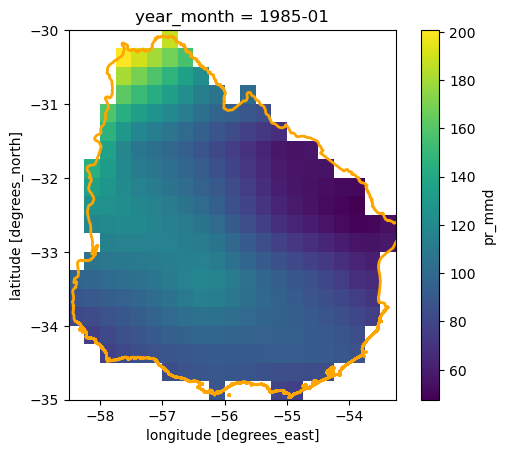

In [4]:
means_plot('filtered_data',month=0,year='1985',variable='pr',model_name='TaiESM1',scenario='historical')

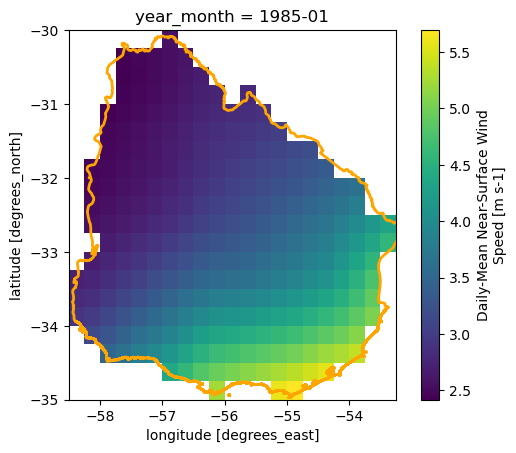

In [5]:
means_plot('filtered_data',month=0,year='1985',variable='sfcWind',model_name='EC-Earth3',scenario='historical')

In [6]:
def monthly_plot(folder, year, variable=None, model_name=None, scenario=None):

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (year is None or year in file) and (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            data = os.path.join(file_path)
            ds_masked = xr.open_dataset(data)
        
            # Create a new coordinate 'year_month' by extracting the year and month
            ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

            if variable=='pr':
                #For precipitation aggregation is the sum of daily values
                ds_monthly = ds_masked.groupby('year_month').sum(dim='time',skipna=False)
            else:
                #For wind speed and temperature aggregation is the mean of daily values
                ds_monthly = ds_masked.groupby('year_month').mean(dim='time',skipna=False)

            if variable=='pr':
                # Compute the spatial mean of 'pr_mmd' for each month
                ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'],skipna=True)
                ds_monthly['pr_mmd'].plot.imshow(x="lon", y="lat", col="year_month", col_wrap=4,aspect=1, size=3)
            else:
                ds_monthly_spatial_mean = ds_monthly[f'{variable}'].mean(dim=['lat', 'lon'],skipna=True)
                ds_monthly[f'{variable}'].plot.imshow(x="lon", y="lat", col="year_month", col_wrap=4,aspect=1, size=3)
            
            plt.show()

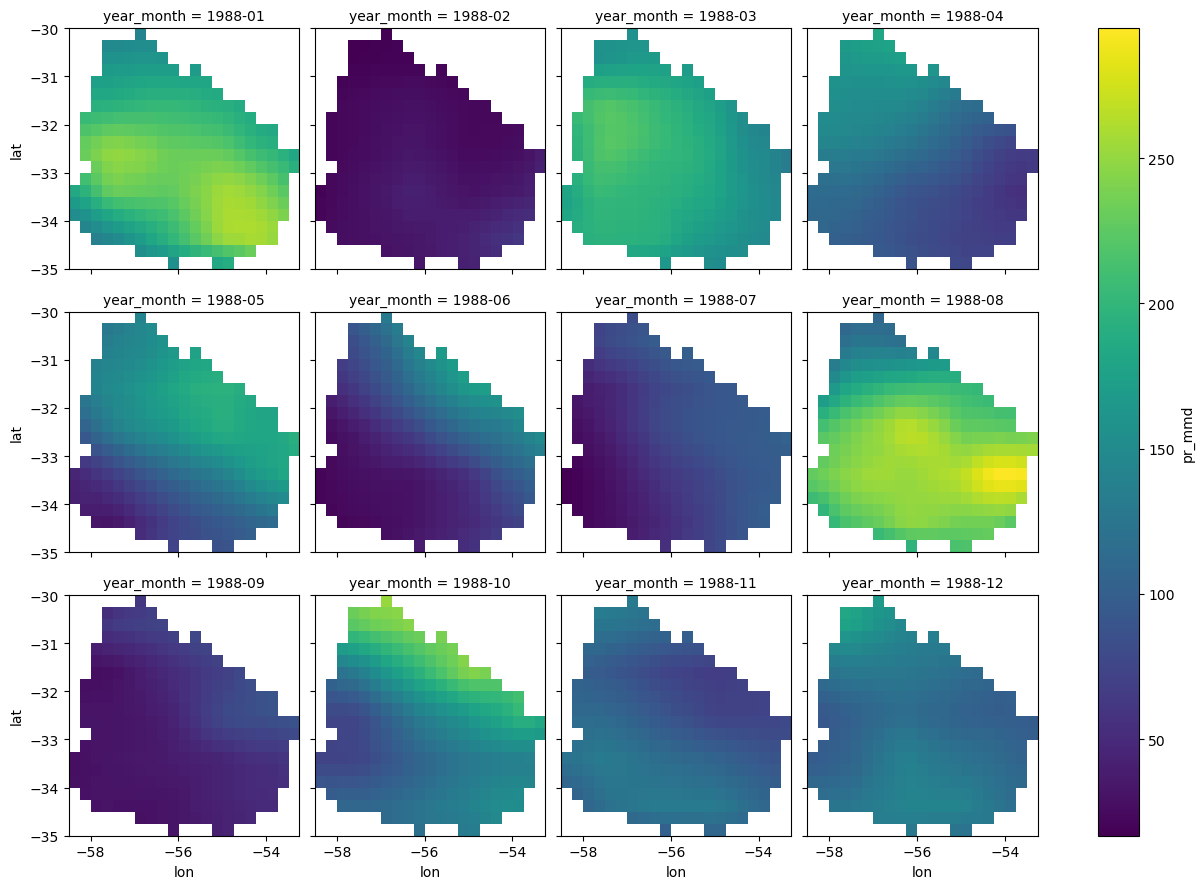

In [7]:
monthly_plot('filtered_data',year='1988',variable='pr',model_name='TaiESM1',scenario='historical')

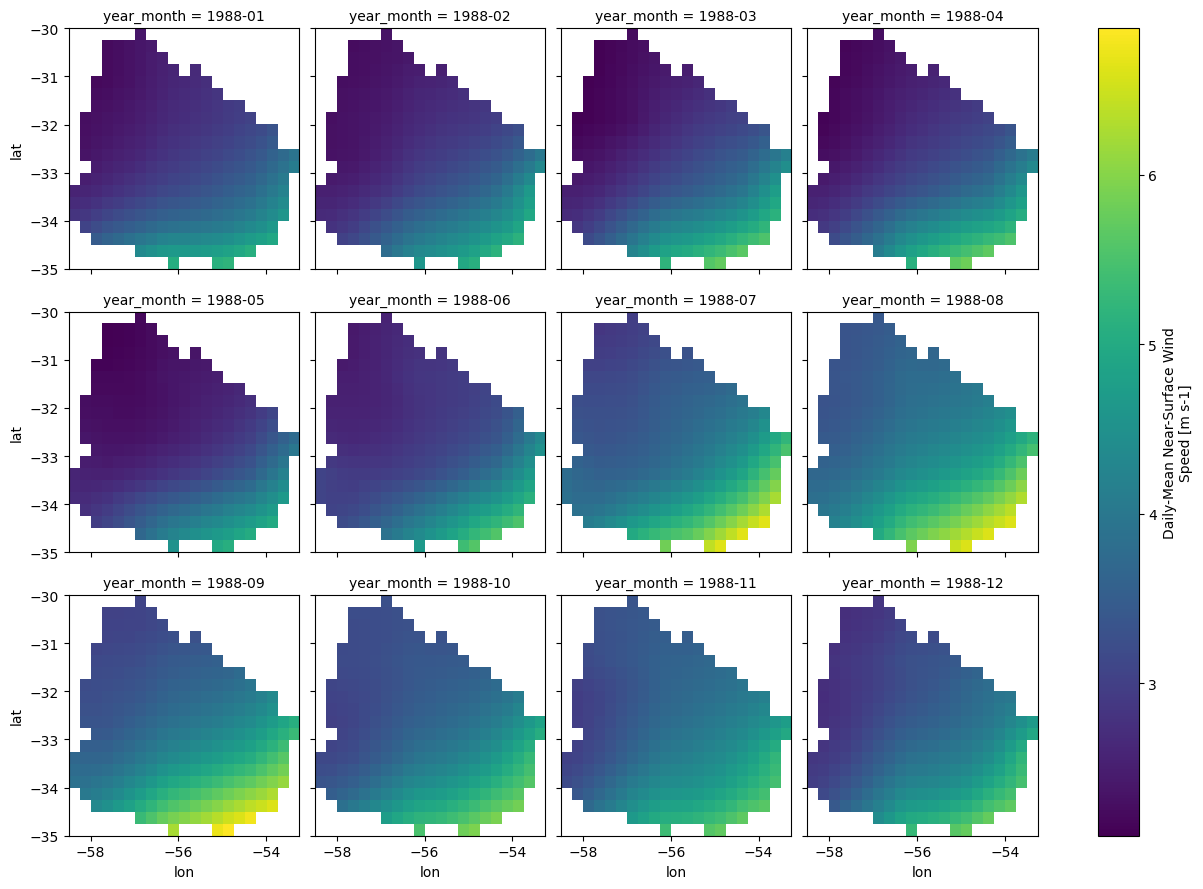

In [8]:
monthly_plot('filtered_data',year='1988',variable='sfcWind',model_name='EC-Earth3',scenario='historical')

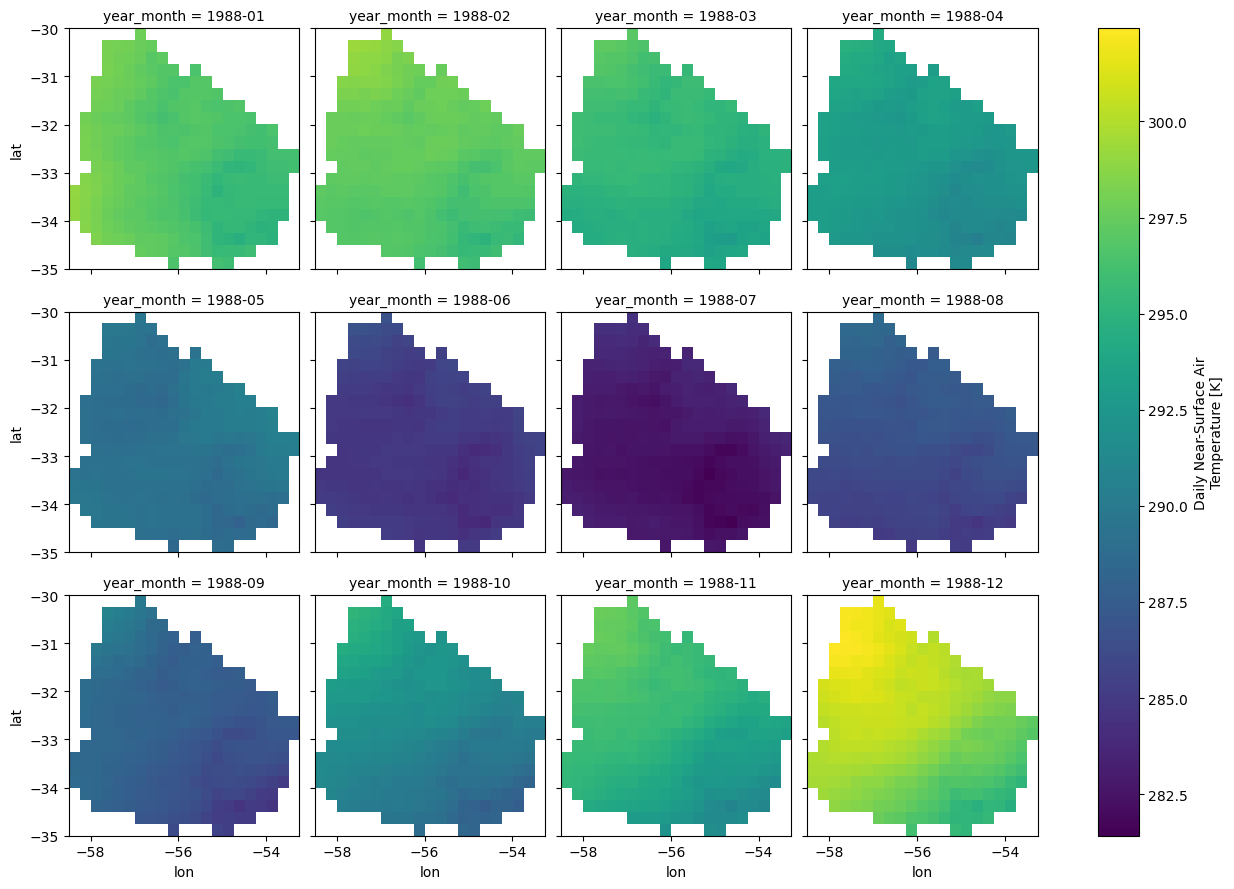

In [9]:
monthly_plot('filtered_data',year='1988',variable='tas',model_name='EC-Earth3',scenario='historical')

In [10]:
def means_dataframe(folder,variable=None, model_name=None, scenario=None):
    dataframes = []

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            ds_masked = xr.open_dataset(file_path)
            ds_masked = ds_masked.assign_coords(year_month=ds_masked.time.dt.strftime('%Y-%m'))
            # ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)

            if variable=='pr':
                #For precipitation aggregation is the sum of daily values
                ds_monthly = ds_masked.groupby('year_month').sum(dim='time',skipna=False)
            else:
                #For wind speed and temperature aggregation is the mean of daily values
                ds_monthly = ds_masked.groupby('year_month').mean(dim='time',skipna=False)
            
            if variable=='pr':
                ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'], skipna=True)
            else:
                ds_monthly_spatial_mean = ds_monthly[variable].mean(dim=['lat', 'lon'], skipna=True)
                
            dataframes.append(ds_monthly_spatial_mean.to_dataframe())

    result=pd.concat(dataframes)
    result=result.sort_values('year_month')
    
    return result

In [11]:
# EC_Earth3_historical=means_dataframe('filtered_data',variable='pr', model_name='EC-Earth3_', scenario='historical')

In [12]:
# EC_Earth3_historical.head()

In [13]:
# TaiESM1_historical=means_dataframe('filtered_data',variable='pr', model_name='TaiESM1', scenario='historical')

In [14]:
# EC_Earth3_ssp126=means_dataframe('filtered_data',variable='pr', model_name='EC-Earth3_', scenario='ssp126')

In [15]:
# TaiESM1_ssp126=means_dataframe('filtered_data',variable='pr', model_name='TaiESM1', scenario='ssp126')

In [16]:
# #Split data into future 1 and future 2
# EC_Earth3_ssp126_2544=EC_Earth3_ssp126.loc['2025-01':'2044-12']
# EC_Earth3_ssp126_4564=EC_Earth3_ssp126.loc['2045-01':'2064-12']
# TaiESM1_ssp126_2544=TaiESM1_ssp126.loc['2025-01':'2044-12']
# TaiESM1_ssp126_4564=TaiESM1_ssp126.loc['2045-01':'2064-12']

In [17]:
def classification(variable,historical_dataframe,dataframe):
    quintile_0=historical_dataframe.quantile(0).item()
    quintile_02=historical_dataframe.quantile(0.2).item()
    quintile_04=historical_dataframe.quantile(0.4).item()
    quintile_06=historical_dataframe.quantile(0.6).item()
    quintile_08=historical_dataframe.quantile(0.8).item()
    quintile_1=historical_dataframe.quantile(1).item()

    output = dataframe.copy()
    year_month=dataframe.index.tolist()
    for i in year_month:
        if variable=='pr':
            var_value=dataframe.loc[i, 'pr_mmd']
        else:
            var_value=dataframe.loc[i, f'{variable}']
            
        if var_value<quintile_0:
            output.loc[i, f'{variable}_cat']=0
        elif  quintile_0 <= var_value < quintile_02:
            output.loc[i, f'{variable}_cat']=1
        elif  quintile_02 <= var_value < quintile_04:
            output.loc[i, f'{variable}_cat']=2
        elif  quintile_04 <= var_value < quintile_06:
            output.loc[i, f'{variable}_cat']=3
        elif  quintile_06 <= var_value < quintile_08:
            output.loc[i, f'{variable}_cat']=4
        elif  quintile_08 <= var_value < quintile_1:
            output.loc[i, f'{variable}_cat']=5
        elif  var_value > quintile_1:
            output.loc[i, f'{variable}_cat']=6
    return output

In [18]:
# EC_Earth3_historical_8514=classification('pr',EC_Earth3_historical,EC_Earth3_historical)
# TaiESM1_historical_8514=classification('pr',TaiESM1_historical,TaiESM1_historical)

In [19]:
# EC_Earth3_ssp126_2544=classification('pr',EC_Earth3_historical,EC_Earth3_ssp126_2544)
# EC_Earth3_ssp126_4564=classification('pr',EC_Earth3_historical,EC_Earth3_ssp126_4564)
# TaiESM1_ssp126_2544=classification('pr',TaiESM1_historical,EC_Earth3_ssp126_2544)
# TaiESM1_ssp126_4564=classification('pr',TaiESM1_historical,TaiESM1_ssp126_4564)

In [20]:
# count=0
# severetiy=0
# episodes_vector=[]
# severity_vector=[]

# year_month=EC_Earth3_ssp126_4564.index.tolist()

# consecutive_months = 0

# for i in year_month:
#     cat=EC_Earth3_ssp126_4564.loc[i, 'pr_cat']
#     if cat <= 2:
#         consecutive_months += 1  # Continue streak
#     else:
#         if consecutive_months >= 3:
#             count += 1
#             episodes_vector.append(count)
#             severity_vector.append(consecutive_months)
#         consecutive_months = 0

In [21]:
# episodes_vector

In [22]:
# severity_vector

In [23]:
# def count_and_severity(variable,dataframe):
#     count=0
#     severetiy=0
#     episodes_vector=[]
#     severity_vector=[]

#     year_month=dataframe.index.tolist()

#     consecutive_months = 0

#     for i in year_month:
#         cat=dataframe.loc[i, f'{variable}_cat']
#         if cat <= 2:
#             consecutive_months += 1  # Continue streak
#         else:
#             if consecutive_months >= 3:
#                 count += 1
#                 episodes_vector.append(count)
#                 severity_vector.append(consecutive_months)
#             consecutive_months = 0
#     return episodes_vector, severity_vector

For temperature I thought that it would be more interesting to see when is higher than normal.

In [24]:
def count_and_severity(variable, dataframe):
    """With variable and the dataframe with categories, build an array of n x n."""
    
    len_months = dataframe.shape[0]
    classification = np.zeros((len_months, len_months))

    year_month = dataframe.index.tolist()

    if variable != 'tas':
        for j in range(len_months):
            for i in range(j, len_months):
                cat = dataframe.loc[year_month[i], f'{variable}_cat']
                if cat <= 2:
                    classification[j, i] = 1
                else:
                    break
    else:
        for j in range(len_months):
            for i in range(j, len_months):
                cat = dataframe.loc[year_month[i], f'{variable}_cat']
                if cat >= 4:
                    classification[j, i] = 1
                else:
                    break

    episodes_vector = np.arange(1, len_months + 1)
    severity_vector = classification.sum(axis=1)  # Tracks consecutive episodes per starting month

    return episodes_vector, severity_vector

In [25]:
# def count_and_severity(variable,dataframe):
#     count=0
#     severetiy=0
#     episodes_vector=[]
#     severity_vector=[]

#     year_month=dataframe.index.tolist()

#     consecutive_months = 0

#     if variable!='tas':
#         for i in year_month:
#             cat=dataframe.loc[i, f'{variable}_cat']
#             if cat <=2:
#                 consecutive_months += 1  # Continue streak
#             else:
#                 if consecutive_months >= 3:
#                     count += 1
#                     episodes_vector.append(count)
#                     severity_vector.append(consecutive_months)
#                 consecutive_months = 0
#     else:
#         for i in year_month:
#             cat=dataframe.loc[i, f'{variable}_cat']
#             if cat >= 4:
#                 consecutive_months += 1  # Continue streak
#             else:
#                 if consecutive_months >= 3:
#                     count += 1
#                     episodes_vector.append(count)
#                     severity_vector.append(consecutive_months)
#                 consecutive_months = 0        
#     return episodes_vector, severity_vector

In [26]:
# episodes_EC_Earth3_historical_8514,severity_EC_Earth3_historical_8514=count_and_severity('pr',EC_Earth3_historical_8514)
# episodes_TaiESM1_historical_8514,severity_TaiESM1_historical_8514=count_and_severity('pr',TaiESM1_historical_8514)

In [27]:
# episodes_EC_Earth3_ssp126_2544,severity_EC_Earth3_ssp126_2544=count_and_severity('pr',EC_Earth3_ssp126_2544)
# episodes_EC_Earth3_ssp126_4564,severity_EC_Earth3_ssp126_4564=count_and_severity('pr',EC_Earth3_ssp126_4564)
# episodes_TaiESM1_ssp126_2544,severity_TaiESM1_ssp126_2544=count_and_severity('pr',TaiESM1_ssp126_2544)
# episodes_TaiESM1_ssp126_4564,severity_TaiESM1_ssp126_4564=count_and_severity('pr',TaiESM1_ssp126_4564)

In [28]:
# episodes_EC_Earth3_ssp126_2544[-1]

In [29]:
# severity_EC_Earth3_historical_8514

In [30]:
# fig, ax = plt.subplots(2,3,figsize=(18,8))

# bins=np.arange(min(severity_EC_Earth3_historical_8514) - 0.5, max(severity_EC_Earth3_historical_8514) + 1.5, 1)

# ax[0,0].hist(severity_EC_Earth3_historical_8514,bins=bins,align='mid',rwidth=0.9)
# ax[0,1].hist(severity_EC_Earth3_ssp126_2544)
# ax[0,2].hist(severity_EC_Earth3_ssp126_4564)
# ax[1,0].hist(severity_TaiESM1_historical_8514)
# ax[1,1].hist(severity_TaiESM1_ssp126_2544)
# ax[1,2].hist(severity_TaiESM1_ssp126_4564)

# ax[0,0].set_title(f'Model:EC_Earth3 | Scenario:historical | Period:1985-2014\nEpisode count = {episodes_EC_Earth3_historical_8514[-1]}')
# ax[0,1].set_title('Model:EC_Earth3 | Scenario:ssp126 | Period:2025-2044')
# ax[0,2].set_title('Model:EC_Earth3 | Scenario:ssp126 | Period:2045-2064')
# ax[1,0].set_title('Model:TaiESM1 | Scenario:historical | Period:1985-2014')
# ax[1,1].set_title('Model:TaiESM1 | Scenario:ssp126 | Period:2025-2044')
# ax[1,2].set_title('Model:TaiESM1 | Scenario:ssp126 | Period:2045-2064')

# # ax[0,0].set_xlim(2,10)

# # ax[0,0].text(5,5,f'Episode count = {episodes_EC_Earth3_historical_8514[-1]}',ha='center', va='top')
# ax[0,1].text(3.4,6,f'Episode count = {episodes_EC_Earth3_ssp126_2544[-1]}')
# ax[0,2].text(3.4,6,f'Episode count = {episodes_EC_Earth3_ssp126_4564[-1]}')
# ax[1,0].text(3.75,6,f'Episode count = {episodes_TaiESM1_historical_8514[-1]}')
# ax[1,1].text(3.75,6,f'Episode count = {episodes_TaiESM1_ssp126_2544[-1]}')
# ax[1,2].text(3.4,4,f'Episode count = {episodes_TaiESM1_ssp126_4564[-1]}')

# plt.show()

**Building dictionary:**
I want something like count_sev_dic['modelo']['periodo']['variable']['severity or count']

In [31]:
count_sev_dic = {
    'EC-Earth3': {
        'historical': {
            'pr': {'severity': [], 'count': []},
            'sfcWind': {'severity': [], 'count': []},
            'tas': {'severity': [], 'count': []}
        },
        'ssp126': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        },
        'ssp370': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        }
    },
    'TaiESM1': {
        'historical': {
            'pr': {'severity': [], 'count': []},
            'sfcWind': {'severity': [], 'count': []},
            'tas': {'severity': [], 'count': []}
        },
        'ssp126': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        },
        'ssp370': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        }
    }
}

I created a dictionary to store severity and count of drought episodes.

In [32]:
folder='filtered_data'
models = ['EC-Earth3','TaiESM1']
variables=['pr','sfcWind','tas']
scenarios=['historical','ssp126','ssp370']

for model in models:
    for variable in variables:
        historical_means = means_dataframe(folder, variable=variable, model_name=model, scenario='historical')
        
        for scenario in scenarios:
            means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
            
            if scenario != 'historical':
                future_1=means.loc['2025-01':'2044-12']
                future_2=means.loc['2045-01':'2064-12']
                
                classified_1=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_1) #toma means mensuales y clasifica
                classified_2=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_2)
                
                episodes_1, severity_1 = count_and_severity(variable, classified_1)
                episodes_2, severity_2 = count_and_severity(variable, classified_2)

                #FUTURE 1
                count_sev_dic[model][scenario][variable]['count']['future_1'].append(episodes_1)  
                count_sev_dic[model][scenario][variable]['severity']['future_1'].append(severity_1)

                #FUTURE 2
                count_sev_dic[model][scenario][variable]['count']['future_2'].append(episodes_2)  
                count_sev_dic[model][scenario][variable]['severity']['future_2'].append(severity_2)  
            else:
                #Historical case
                means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
                classified=classification(variable=variable,historical_dataframe=historical_means,dataframe=means) #toma means mensuales y clasifica
            
                episodes, severity = count_and_severity(variable, classified)  
                count_sev_dic[model][scenario][variable]['count'].append(episodes)  
                count_sev_dic[model][scenario][variable]['severity'].append(severity)    

In [33]:
# def histograms(variable=None, model_names=None, scenarios=None):
#     """Plots histograms for different models, scenarios, and time periods."""
    
#     fig, ax = plt.subplots(2, 3, figsize=(18, 8))

#     periods = ['historical', 'future_1', 'future_2']
#     titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

#     for i, model in enumerate(model_names):
#         for j, period in enumerate(periods):
#             try:
#                 if period == 'historical':
#                     severity_data = count_sev_dic[model][period][variable]['severity']
#                 else:
#                     severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]

#                 values, counts = np.unique(severity_data, return_counts=True)
                
#                 # this is to ser the bar width relative to the x axis limits
#                 x_min, x_max = min(values), max(values)
#                 bar_width = (x_max - x_min) / len(values) * 0.5 if len(values) > 1 else 0.8  
                
#                 ax[i, j].bar(values, counts, width=bar_width, label=f'Episode count: {sum(counts)}')
#                 ax[i, j].set_title(f'Model: {model} | Scenario: {scenarios} | {titles[j]}')
#                 ax[i, j].legend()
#                 ax[i, j].set_xticks(values)

#             except KeyError:
#                 ax[i, j].set_title(f'Model: {model} | {titles[j]}\nData not available')

#     plt.tight_layout()
#     plt.show()

**HISTOGRAMS**

In [34]:
def histograms(variable=None, model_names=None, scenarios=None):
    """Plots histograms for different models, scenarios, and time periods."""
    
    fig, ax = plt.subplots(2, 3, figsize=(18, 8))

    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

    for i, model in enumerate(model_names):
        for j, period in enumerate(periods):
            try:
                if period == 'historical':
                    severity_data = count_sev_dic[model][period][variable]['severity']
                    count_data = count_sev_dic[model][period][variable]['count']
                else:
                    severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]
                    count_data = count_sev_dic[model][scenarios][variable]['count'][period]

                if not count_data or not severity_data: 
                    ax[i, j].set_title(f'Model: {model} | {titles[j]}\nNo episodes')
                    continue 

                values, counts = np.unique(severity_data, return_counts=True)

                if len(values) == 0:  
                    ax[i, j].set_title(f'Model: {model} | {titles[j]}\nNo episodes')
                    continue  

                # this is to ser the bar width relative to the x axis limits
                x_min, x_max = min(values), max(values)
                bar_width = (x_max - x_min) / len(values) * 0.5 if len(values) > 1 else 0.8  

                ax[i, j].bar(values, counts, width=bar_width, label=f'Episode count: {sum(counts)}')
                ax[i, j].set_title(f'{titles[j]} | Model: {model}')
                ax[i, j].legend()
                ax[i, j].set_xticks(values)
                ax[i, j].set_yscale('log') 

            except KeyError:
                ax[i, j].set_title(f'{titles[j]} - Data not available')

    fig.suptitle(f"Histograms - Variable: {variable} | Scenario: {scenarios}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

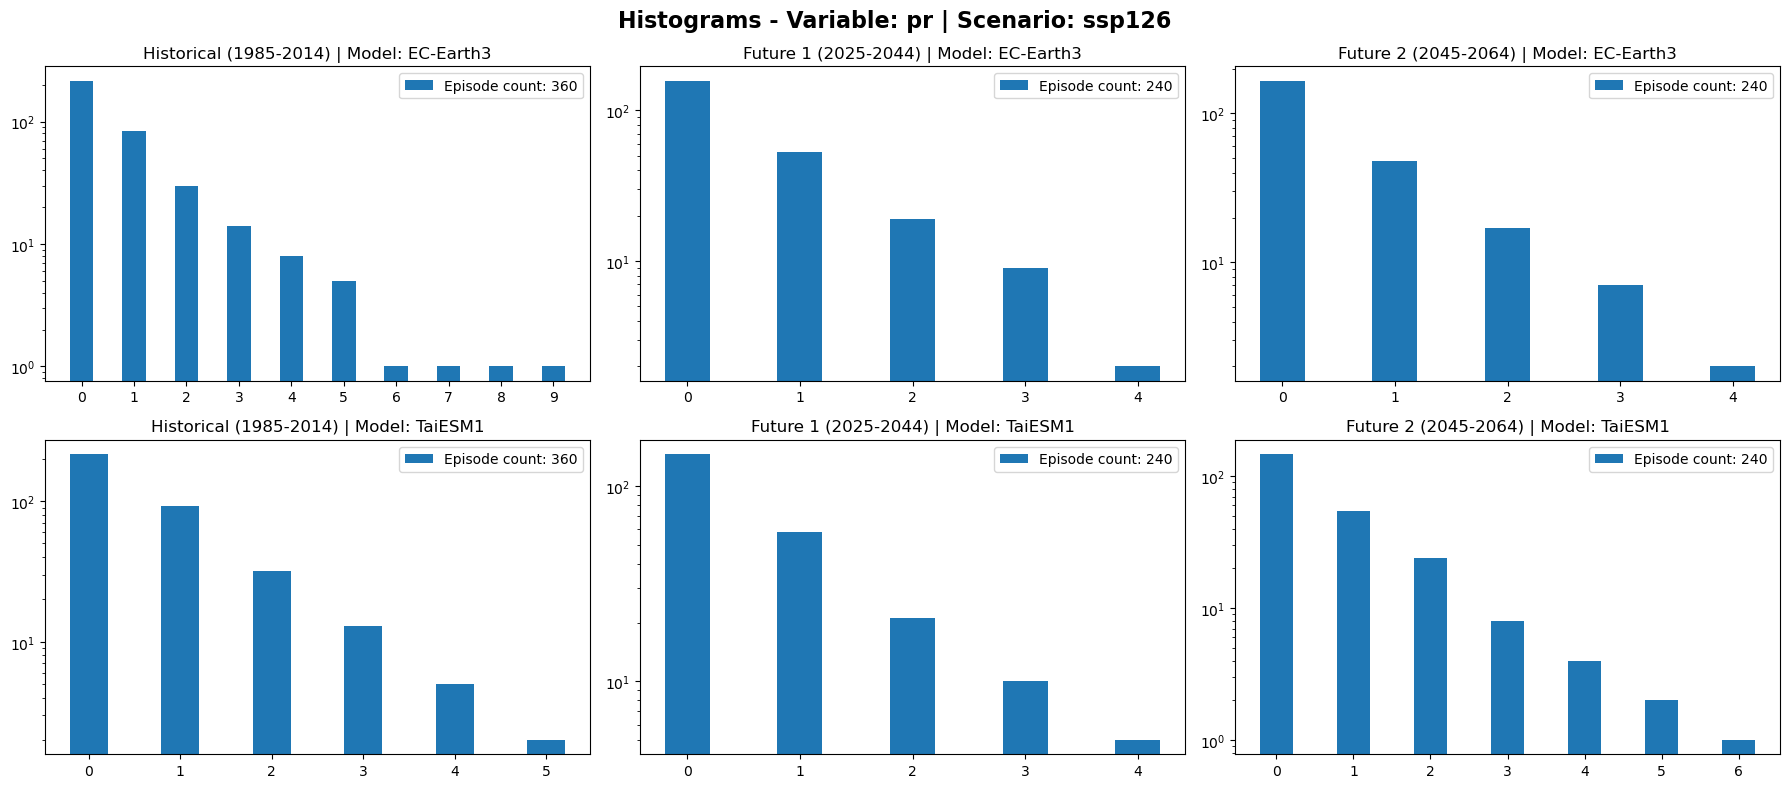

In [35]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp126'

histograms(variable=variables, model_names=models, scenarios=scenario)

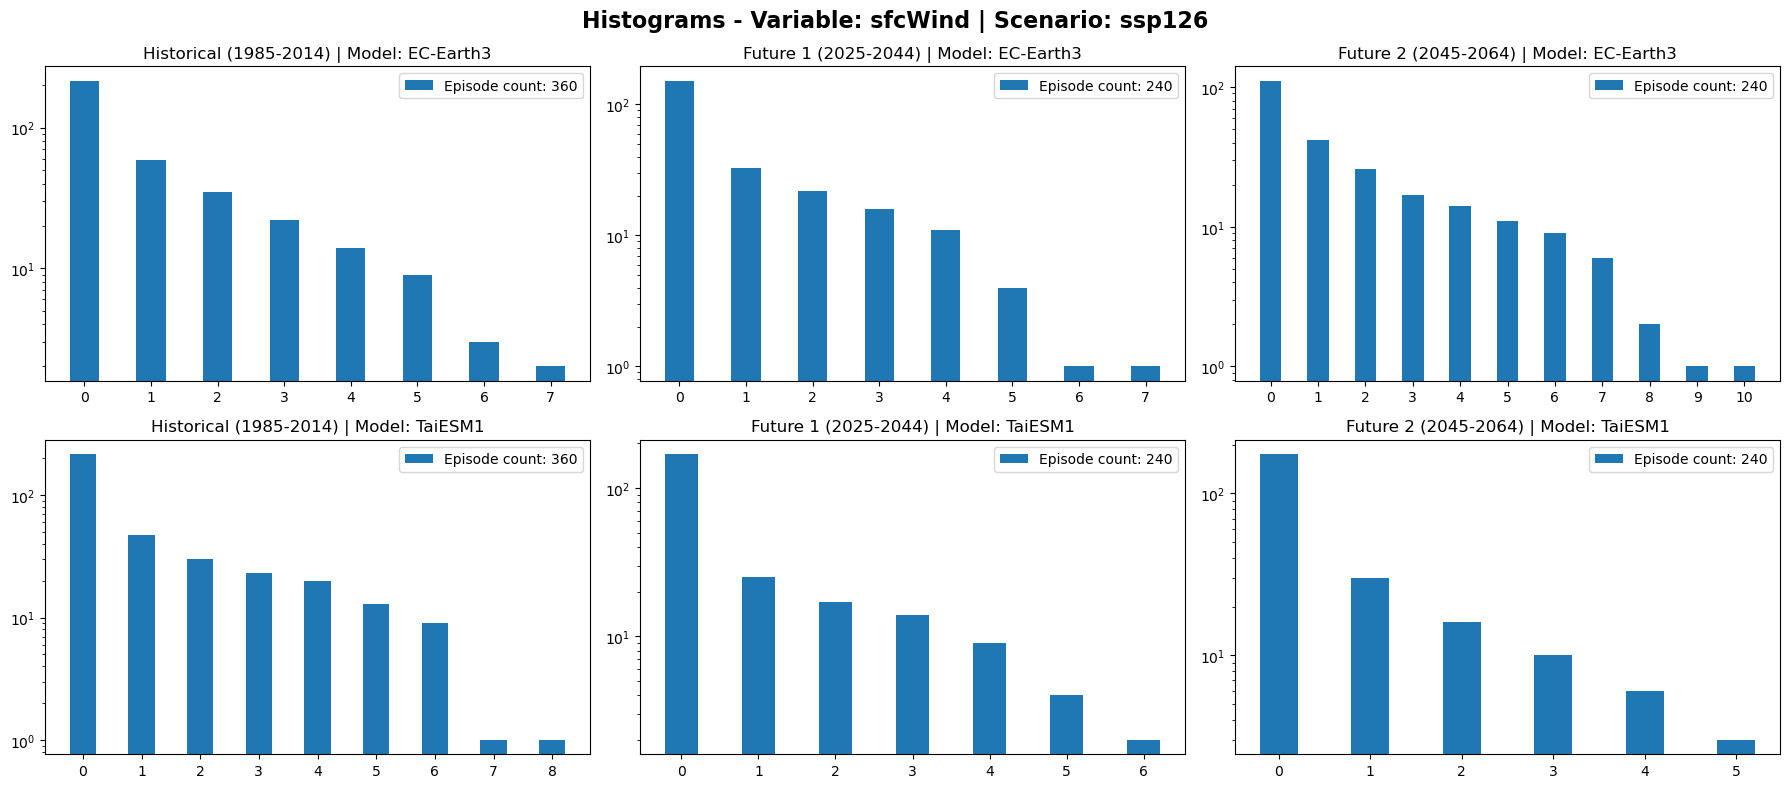

In [36]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp126'

histograms(variable=variables, model_names=models, scenarios=scenario)

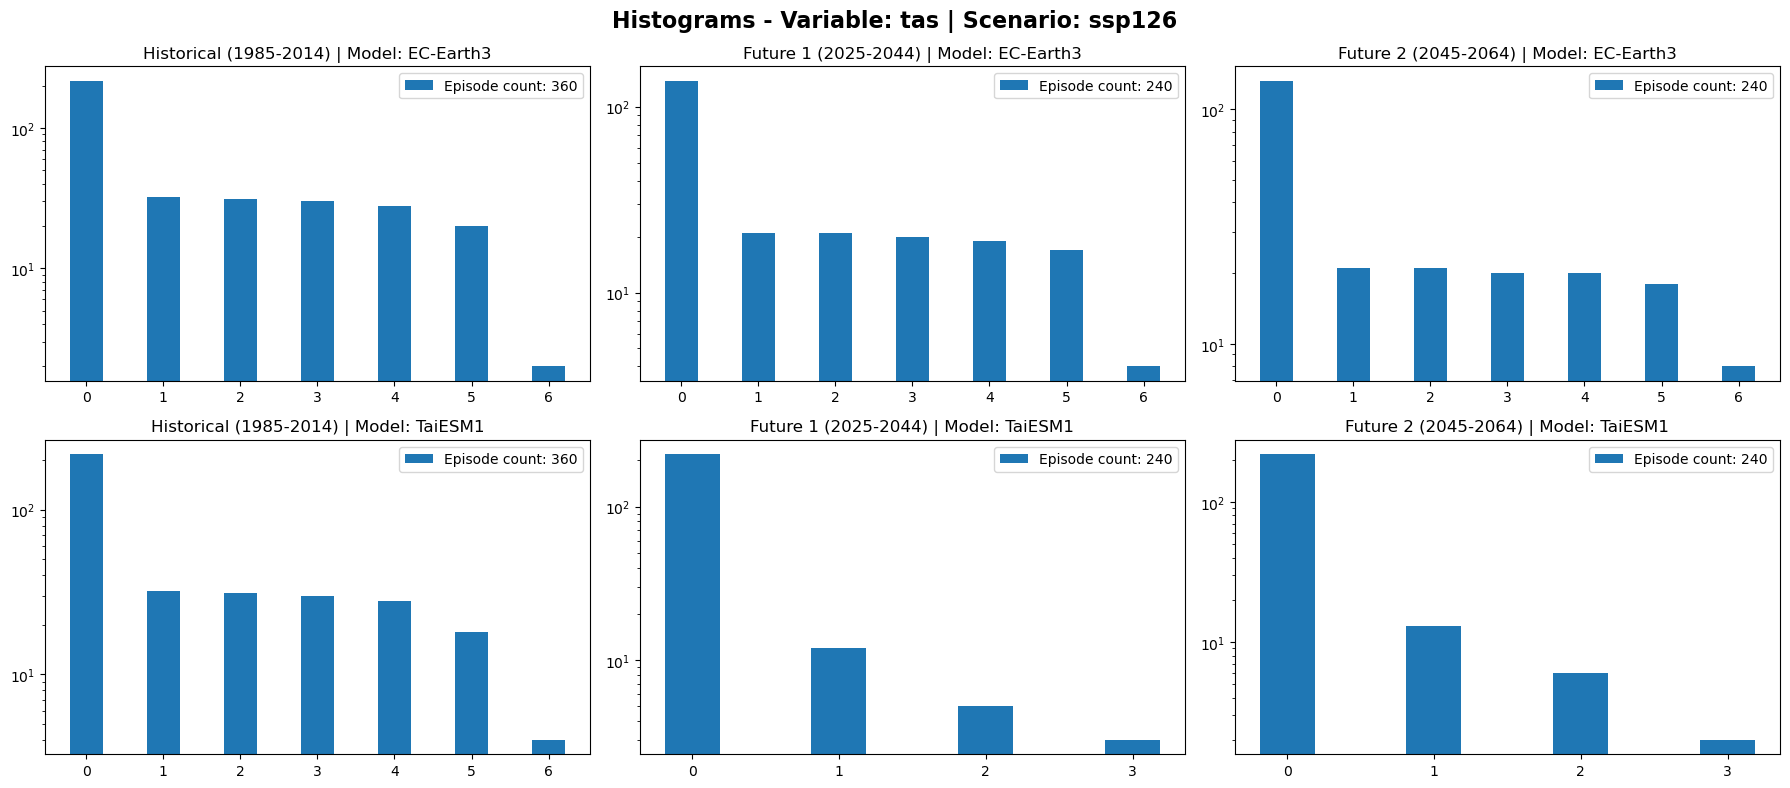

In [37]:
models =['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp126'

histograms(variable=variables, model_names=models, scenarios=scenario)

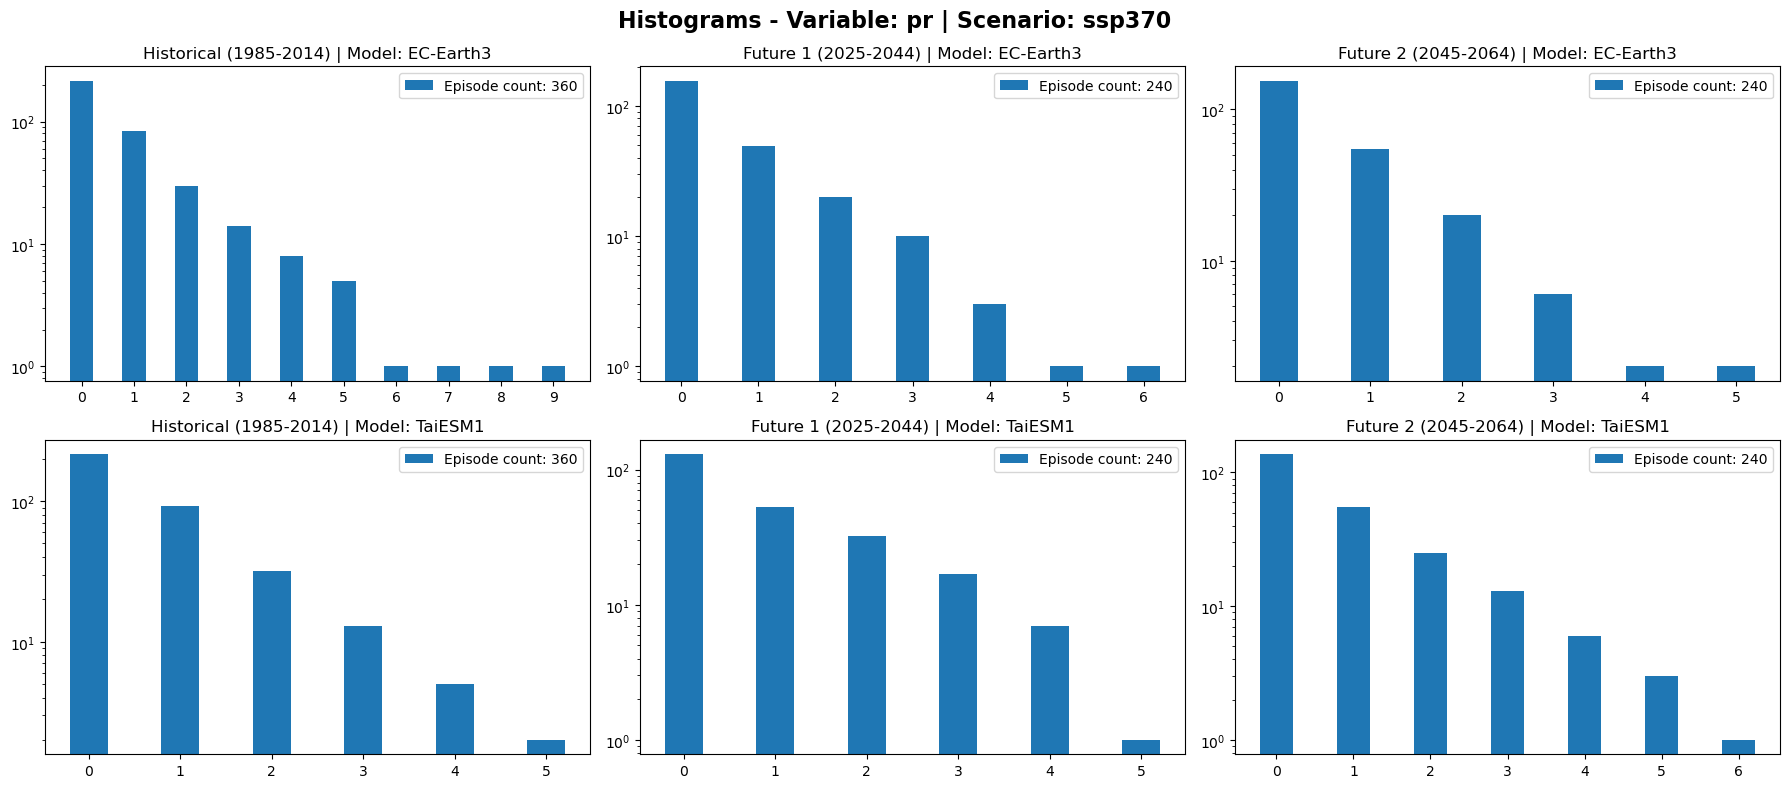

In [38]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp370'

histograms(variable=variables, model_names=models, scenarios=scenario)

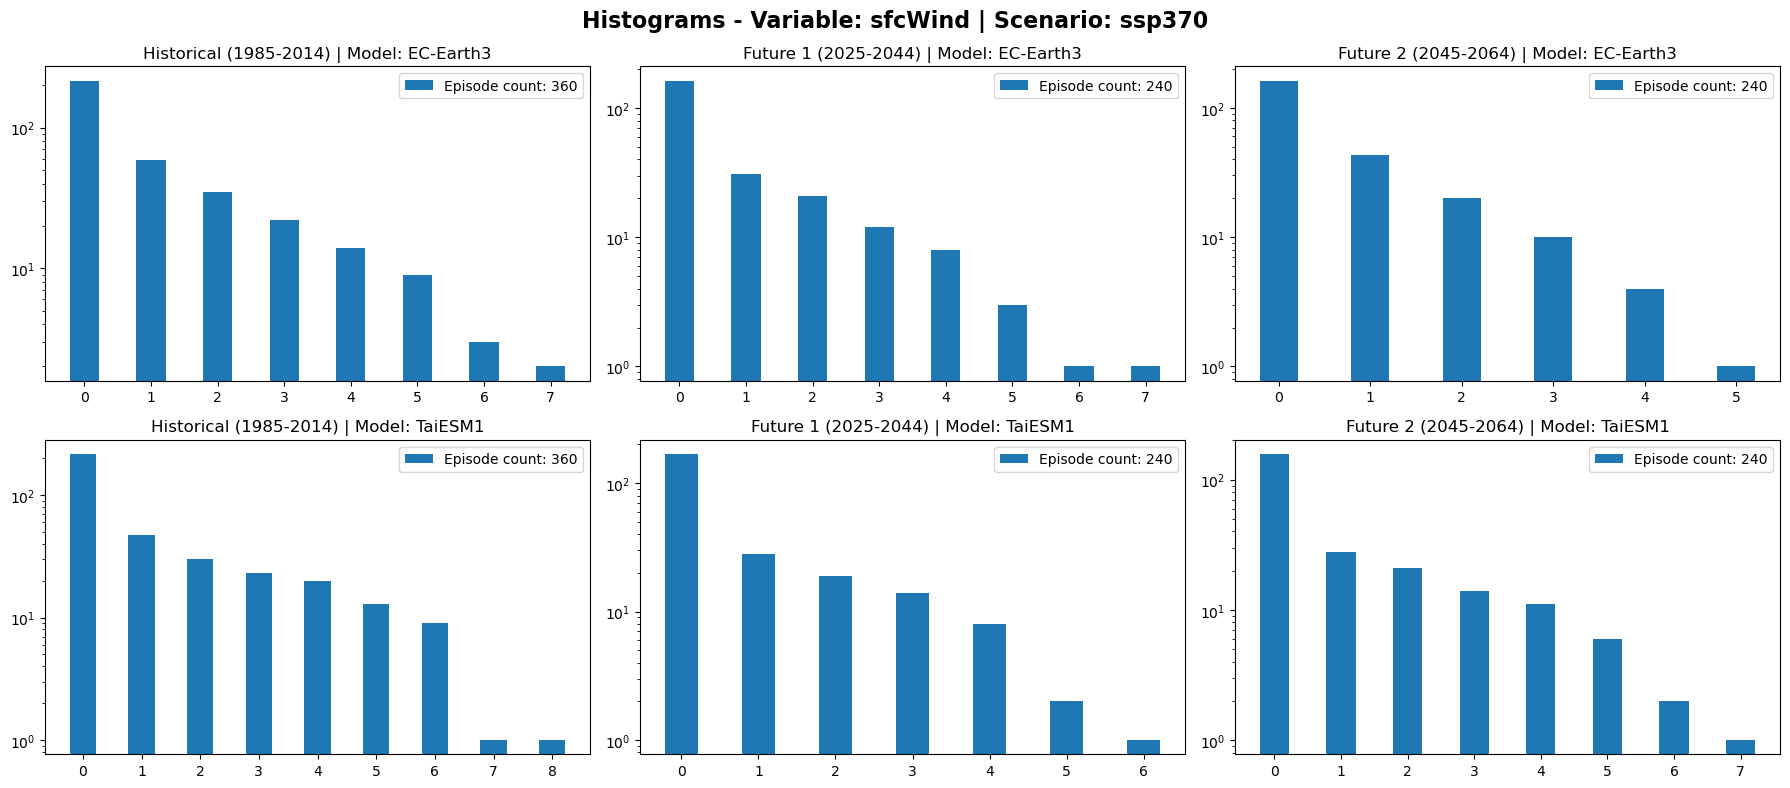

In [39]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp370'

histograms(variable=variables, model_names=models, scenarios=scenario)

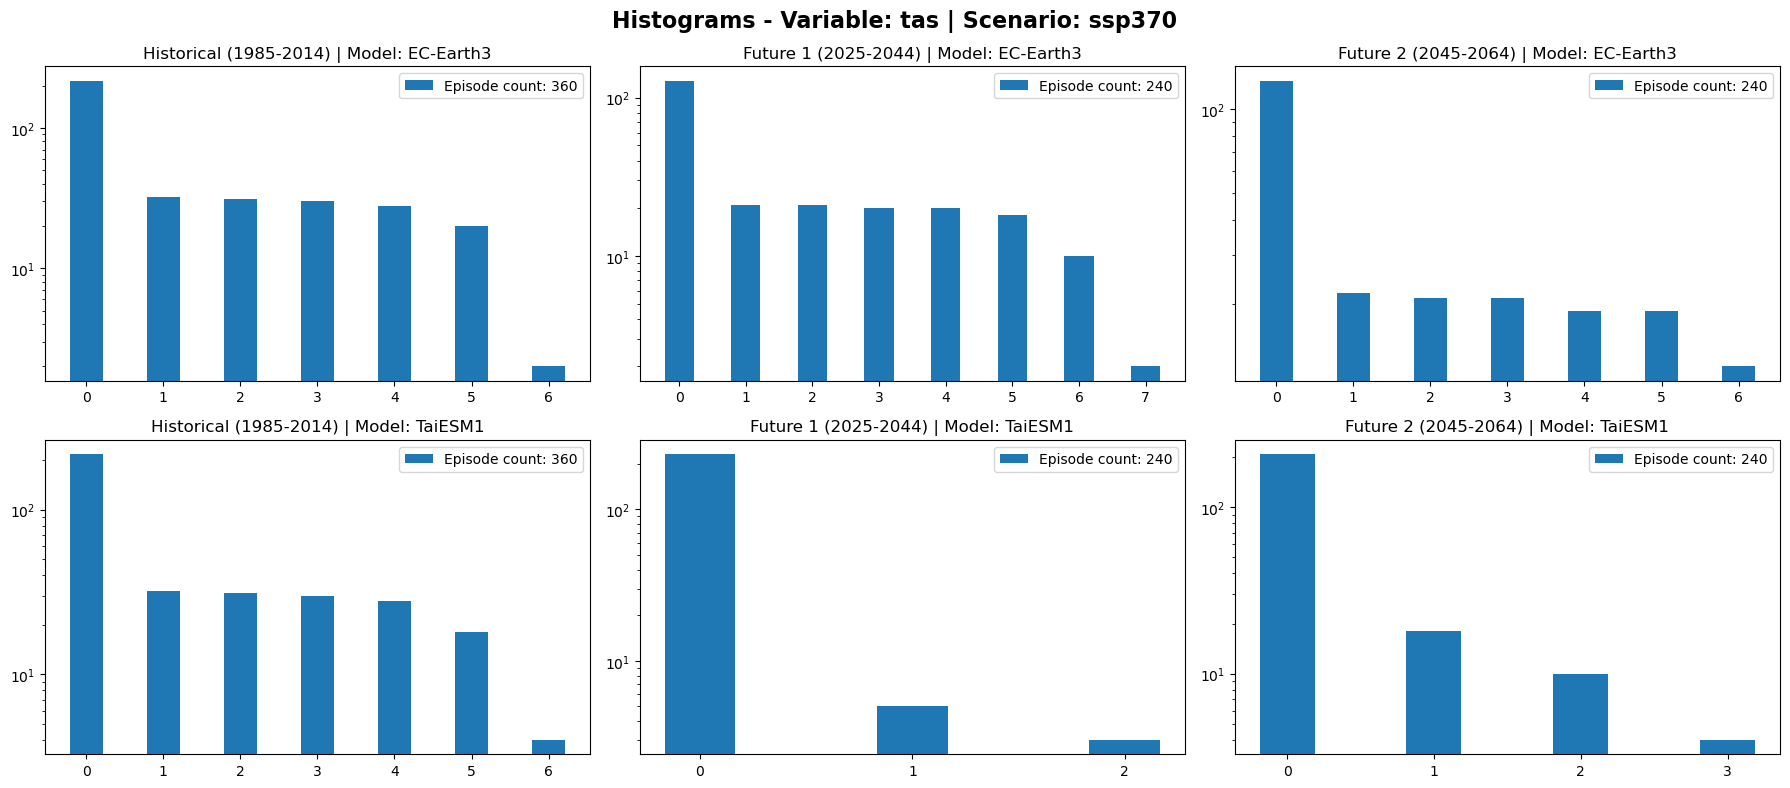

In [40]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp370'

histograms(variable=variables, model_names=models, scenarios=scenario)

**COLORMAPS**

Here I created a dictionary to store classifications for eash variable, period and model. Months categories equal or lower than 2 are shown in red.

In [41]:
classification_dic = {
    'EC-Earth3': {
        'historical': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp126': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp370': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        }
    },
    'TaiESM1': {
        'historical': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp126': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp370': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        }
    }
}

In [42]:
folder='filtered_data'
models = ['EC-Earth3','TaiESM1']
variables=['pr','sfcWind','tas']
scenarios=['historical','ssp126','ssp370']

for model in models:
    for variable in variables:
        historical_means = means_dataframe(folder, variable=variable, model_name=model, scenario='historical')
        
        for scenario in scenarios:
            means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
            
            if scenario != 'historical':
                future_1=means.loc['2025-01':'2044-12']
                future_2=means.loc['2045-01':'2064-12']
                
                classified_1=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_1) #toma means mensuales y clasifica
                classified_2=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_2)

                #FUTURE 1
                classification_dic[model][scenario][variable].append(classified_1[f'{variable}_cat'])  

                #FUTURE 2
                classification_dic[model][scenario][variable].append(classified_2[f'{variable}_cat'])  
            else:
                #Historical case
                means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
                classified=classification(variable=variable,historical_dataframe=historical_means,dataframe=means) #toma means mensuales y clasifica
            
                classification_dic[model][scenario][variable].append(classified[f'{variable}_cat'])  

In [43]:
# classified=classification_dic['EC-Earth3']['ssp126']['pr']
# classified[1]

In [44]:
# plt.subplots(figsize=(30,3))
# plt.plot(range(1,241),classified[1],marker='o')
# plt.axhline(y=2, color='red', linestyle='--', linewidth=2)
# plt.xlim(0,240)

In [45]:
# df = pd.DataFrame(classified[1])
# df

In [46]:
# change_points = (df['pr_cat'] <= 2).astype(int).diff().ne(0)

# # Plotting
# plt.figure(figsize=(12, 6))

# # Draw horizontal segments with alternating colors
# start_idx = 0
# for idx in np.where(change_points)[0]:
#     color = 'red' if df['pr_cat'].iloc[start_idx] <= 2 else 'blue'
#     plt.hlines(1, df.index[start_idx], df.index[idx], colors=color, linewidth=3)
#     start_idx = idx

# # Add the final segment
# color = 'red' if df['pr_cat'].iloc[start_idx] <= 2 else 'blue'
# plt.hlines(1, df.index[start_idx], df.index[-1], colors=color, linewidth=3)

# plt.title('On-Off Horizontal Line')
# plt.xlabel('Year-Month')
# plt.yticks([])  # Remove y-axis ticks for clarity
# plt.show()

In [47]:
# # Create a colormap array (1 for red, 0 for blue)
# colormap_values = np.where(df <= 2, 1, 0).reshape(1, -1)

# # Plotting
# plt.figure(figsize=(12, 2))
# plt.imshow(colormap_values, cmap='coolwarm', aspect='auto') #, extent=[0, len(df), 0, 1])

# # X-axis setup (Final Fix)
# # plt.xticks(np.linspace(0, len(df), 10), df.index[::len(df)//10].strftime('%Y-%m'))
# plt.yticks([])  # Hide y-axis labels for a clean look

# plt.title('On-Off Colormap')
# plt.show()

In [48]:
def colormaps(variable=None, model_names=None, scenarios=None):
    """Plots scatter plots for different models, scenarios, and time periods using classification_dic."""
    
    fig, ax = plt.subplots(2, 3, figsize=(18, 4))

    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

    for i, model in enumerate(model_names):
        for j, period in enumerate(periods):
            if period == 'historical':
                classified_data = classification_dic[model]['historical'][variable]

            elif period == 'future_1':
                classified_data = classification_dic[model][scenarios][variable][0]

            elif period == 'future_2':
                classified_data = classification_dic[model][scenarios][variable][1]
                
            df = pd.DataFrame(classified_data)
            colormap_values = np.where(df <= 2, 1, 0).reshape(1, -1)
            ax[i, j].imshow(colormap_values, cmap='coolwarm', aspect='auto')
            ax[i, j].set_title(f'{titles[j]} | Model: {model}')
            ax[i, j].set_yticks([])

    # title for the entire figure
    fig.suptitle(f"Colormaps - Variable: {variable} | Scenario: {scenarios}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

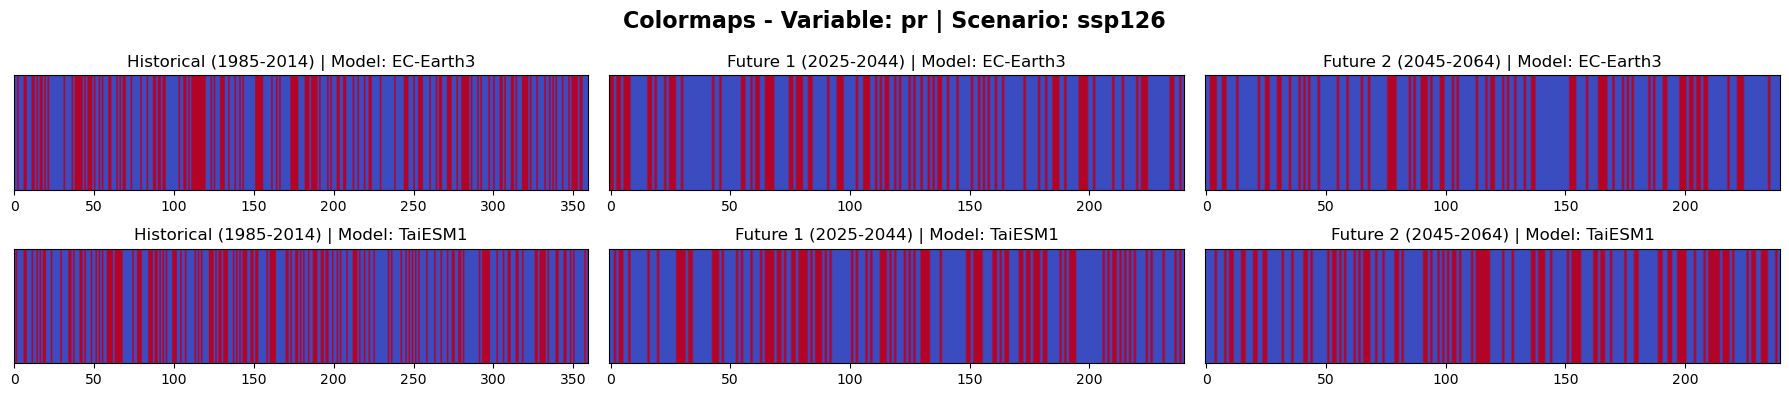

In [49]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp126'

colormaps(variable=variables, model_names=models, scenarios=scenario)

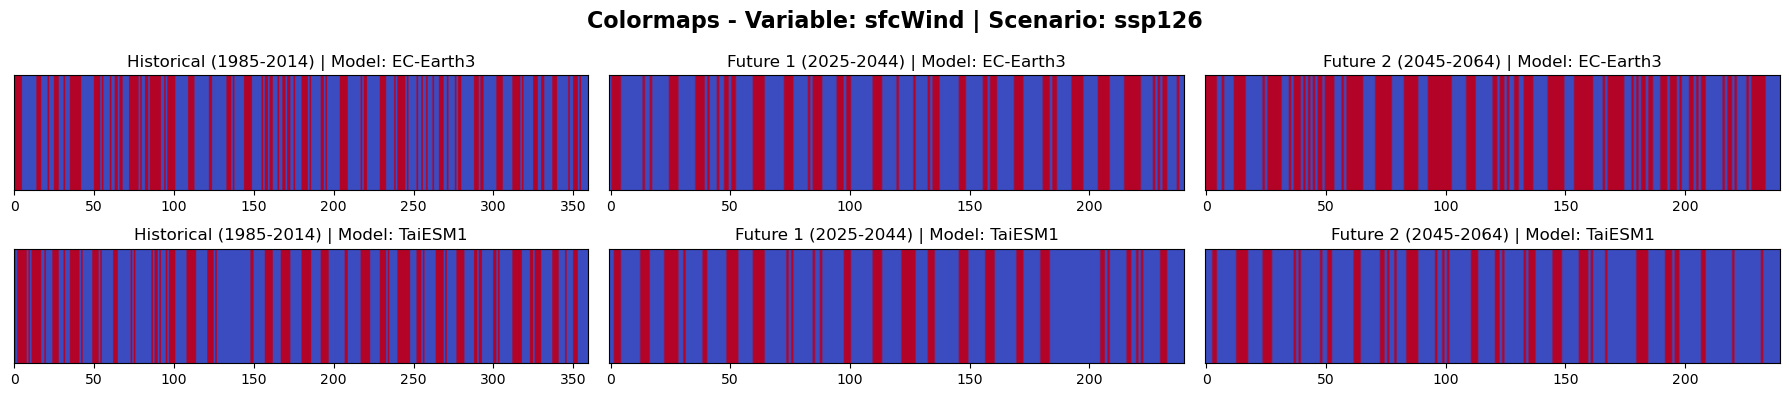

In [50]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp126'

colormaps(variable=variables, model_names=models, scenarios=scenario)

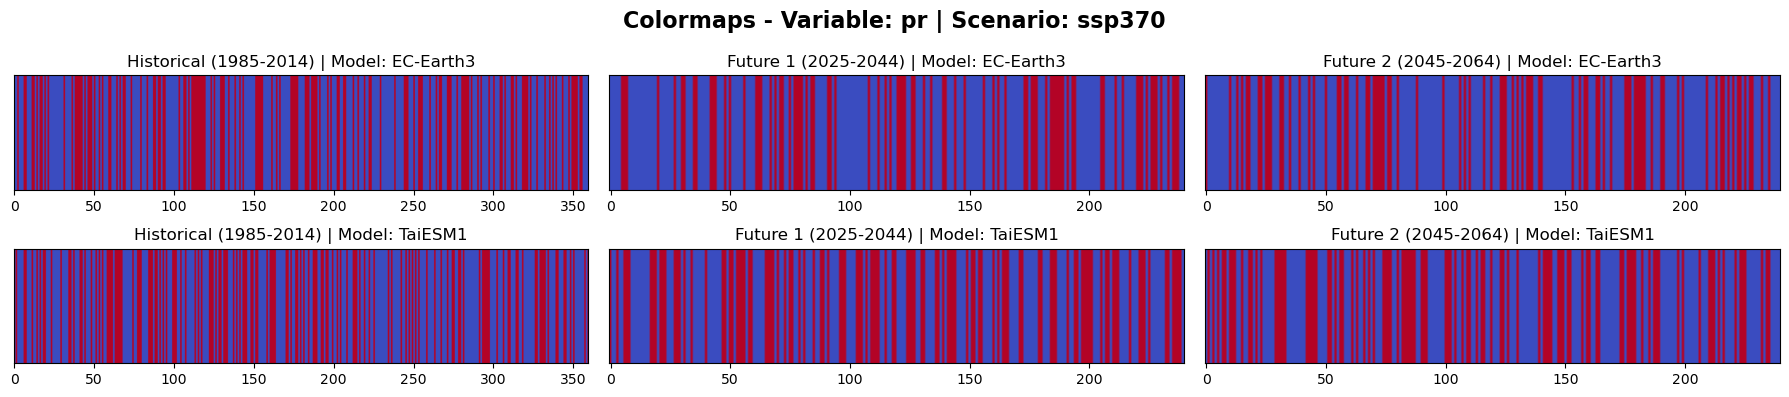

In [51]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp370'

colormaps(variable=variables, model_names=models, scenarios=scenario)

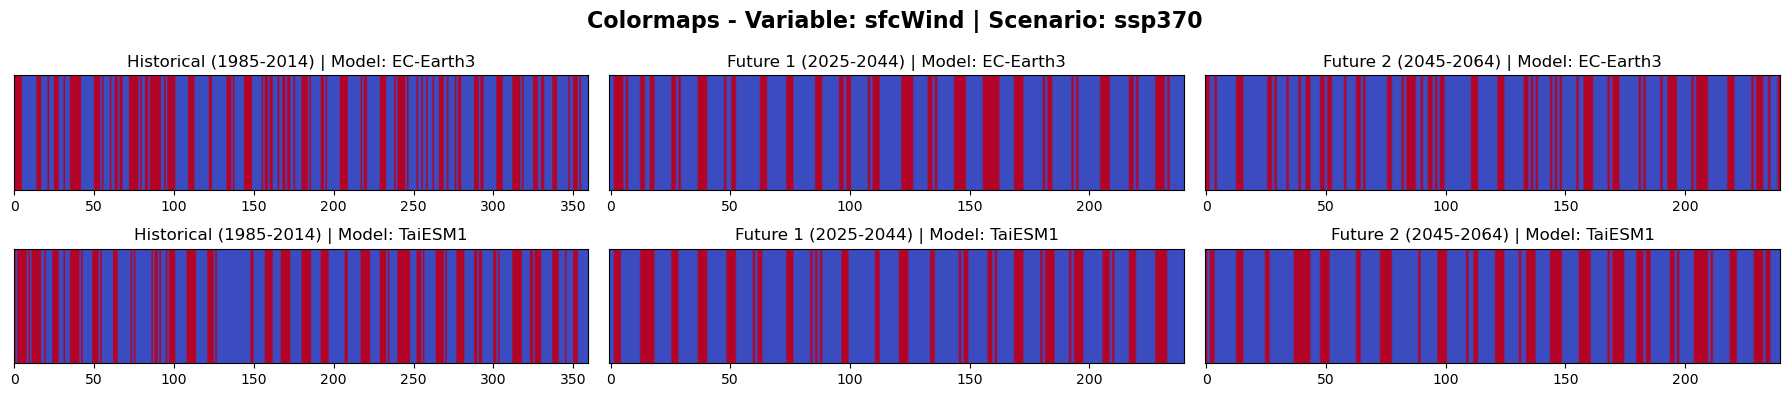

In [52]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp370'

colormaps(variable=variables, model_names=models, scenarios=scenario)

I created other function for tas colormaps because I am plotting in red above category 4, and not below category 2.

In [53]:
def colormaps_tas(variable=None, model_names=None, scenarios=None):
    """Plots scatter plots for different models, scenarios, and time periods using classification_dic."""
    
    fig, ax = plt.subplots(2, 3, figsize=(18, 4))

    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

    for i, model in enumerate(model_names):
        for j, period in enumerate(periods):
            if period == 'historical':
                classified_data = classification_dic[model]['historical'][variable]

            elif period == 'future_1':
                classified_data = classification_dic[model][scenarios][variable][0]

            elif period == 'future_2':
                classified_data = classification_dic[model][scenarios][variable][1]
                
            df = pd.DataFrame(classified_data)
            colormap_values = np.where(df >= 4, 1, 0).reshape(1, -1)
            ax[i, j].imshow(colormap_values, cmap='coolwarm', aspect='auto')
            ax[i, j].set_title(f'{titles[j]} | Model: {model}')
            ax[i, j].set_yticks([])

    # title for the entire figure
    fig.suptitle(f"Colormaps - Variable: {variable} | Scenario: {scenarios}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

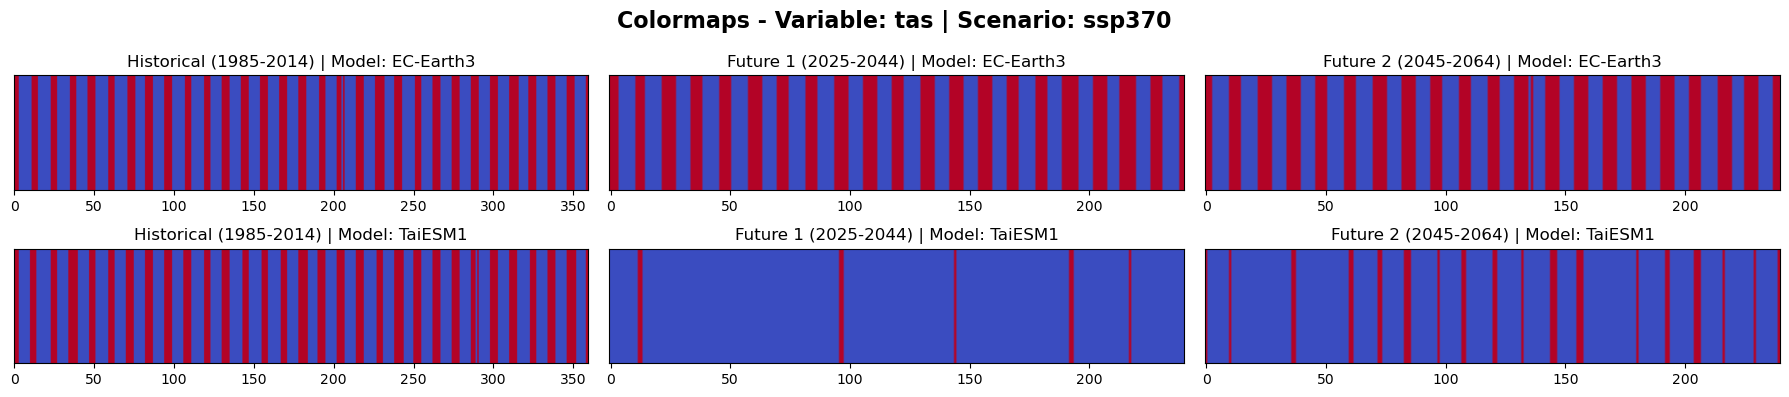

In [54]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp370'

colormaps_tas(variable=variables, model_names=models, scenarios=scenario)

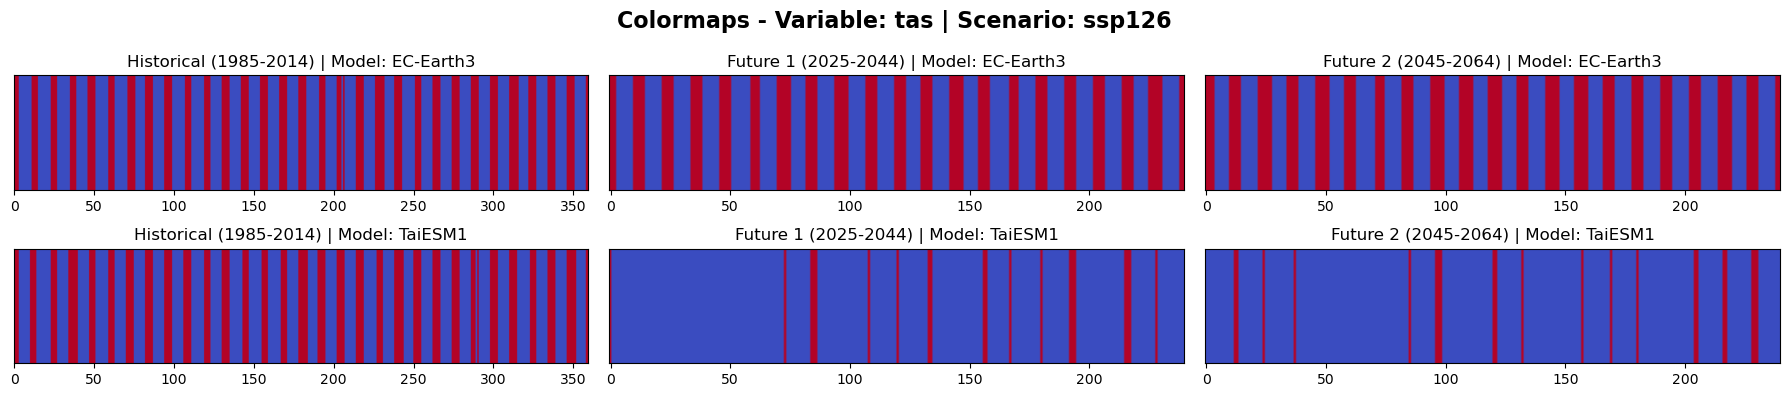

In [55]:
models =['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp126'

colormaps_tas(variable=variables, model_names=models, scenarios=scenario)

**RETURNING PERIOD PLOTS**

In [56]:
# def returning_periods(count_sev_dic=count_sev_dic,variable=None, model_names=None, scenarios=None):
#     """Plots of returning periods for different models, scenarios, and time periods."""

#     periods = ['historical', 'future_1', 'future_2']
#     titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

#     for period, title in zip(periods, titles):
#         if period == 'historical':
#             severity_data = count_sev_dic[model_names][period][variable]['severity']
#         else:
#             severity_data = count_sev_dic[model_names][scenarios][variable]['severity'][period]

#         # flatten the severity data list (GPT)
#         flattened_data = [item for sublist in severity_data for item in sublist]
        
#         # create counts with missing values filled as 0 (GPT)
#         min_value = min(flattened_data)
#         max_value = max(flattened_data)
#         counts = {i: flattened_data.count(i) for i in range(min_value, max_value + 1)}
        
#         normalized_values = [30 / value if value != 0 else 0 for value in counts.values()]
        
#         labels = list(counts.keys())
#         plt.plot(labels, normalized_values, marker='o', linestyle='-', label=title)
    
#     plt.xlabel('Values')
#     plt.ylabel('Returning period')
#     plt.title(f'Returning period -  Model: {model_names} | Scenario: {scenarios}')
#     plt.legend()  
#     plt.grid(True)
#     plt.show()

In [57]:
# models = 'EC-Earth3'
# variables='pr'
# scenario='ssp126'

# returning_periods(variable=variables, model_names=models, scenarios=scenario)

In [87]:
def returning_periods_2(count_sev_dic=count_sev_dic,variable=None, model_names=None, scenarios=None):
    """Plots of returning periods for different models, scenarios, and time periods."""

    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

    fig,ax=plt.subplots(1,2,figsize=(14,6))
    
    for i,model in enumerate(model_names):
        for period, title in zip(periods, titles):
            if period == 'historical':
                severity_data = count_sev_dic[model][period][variable]['severity']
            else:
                severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]
        
            # flatten the severity data list (GPT)
            flattened_data = [item for sublist in severity_data for item in sublist]
            
            # # create counts with missing values filled as 0 (GPT)
            # min_value = min(flattened_data)
            # max_value = max(flattened_data)
            # counts = {i: flattened_data.count(i) for i in range(min_value, max_value + 1)}

            # # normalized_values = [30 / value if value != 0 else 0 for value in counts.values()]
            
            if period == 'historical': 
                normalized_values = [30 / value if value != 0 else 0 for value in flattened_data]
                ax[i].scatter(flattened_data, normalized_values, marker='o', label=title)
            elif period== 'future_1':
                normalized_values = [20 / value if value != 0 else 0 for value in flattened_data]
                ax[i].scatter(flattened_data, normalized_values, marker='s', label=title,s=50)
            elif period== 'future_2':
                normalized_values = [20 / value if value != 0 else 0 for value in flattened_data]
                ax[i].scatter(flattened_data, normalized_values, marker='D', label=title)
            
            # ax[i].scatter(flattened_data, normalized_values, marker='o', label=title)
    
            ax[i].set_xlabel('Values')
            ax[i].set_ylabel('Returning period')
            ax[i].set_title(f'Model: {model}')
            ax[i].legend()  
            ax[i].set_yscale('log') 
            ax[i].grid(True)

    plt.suptitle(f'Returning period -  Variable: {variable} | Scenario: {scenarios}')
    plt.show()

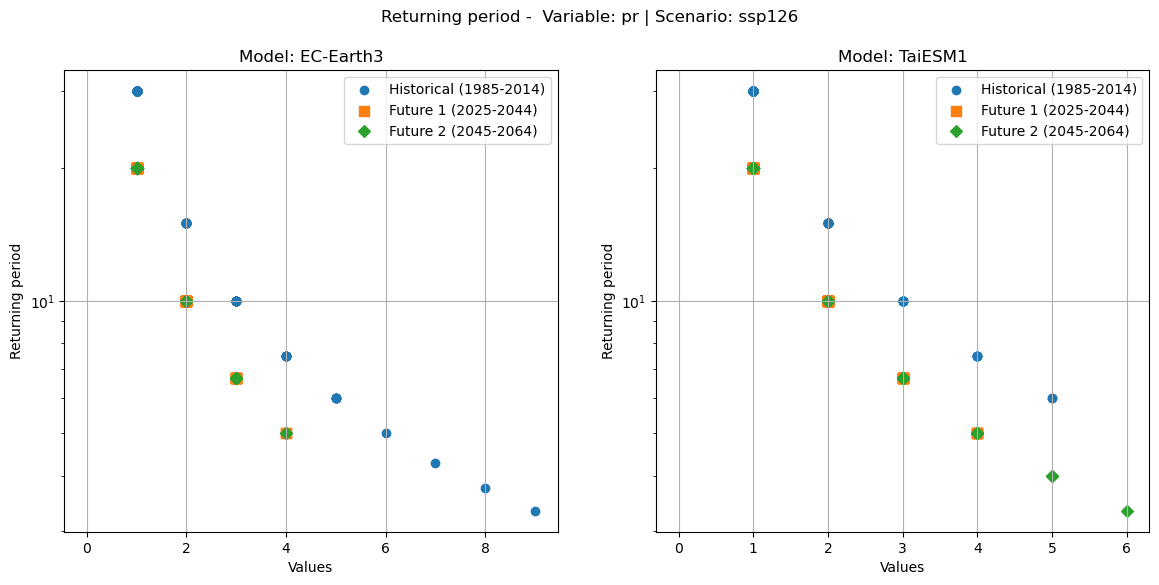

In [88]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp126'

returning_periods_2(variable=variables, model_names=models, scenarios=scenario)

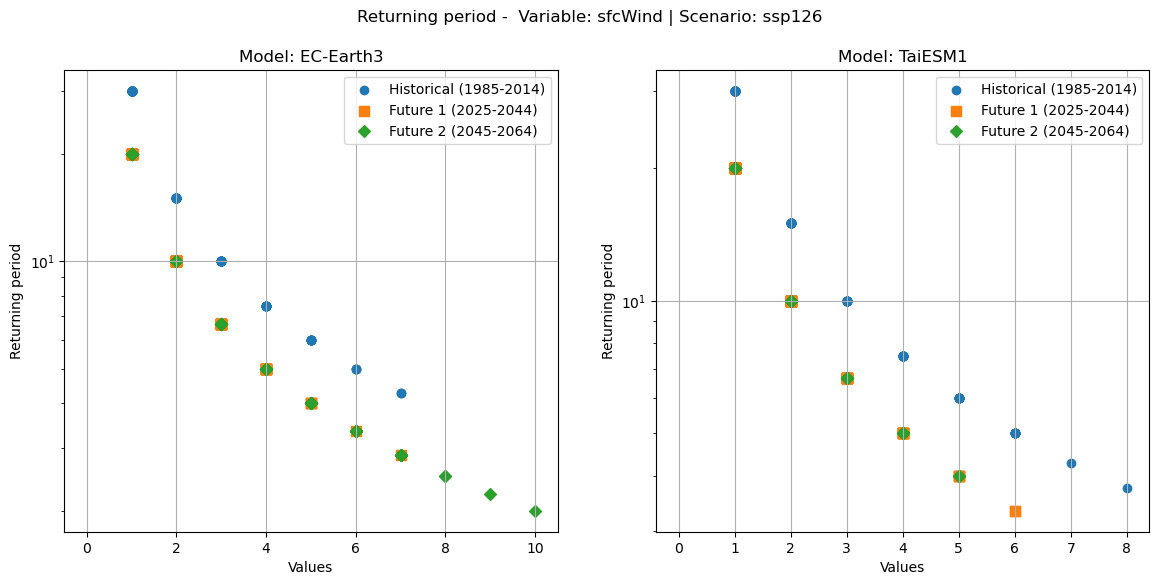

In [89]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp126'

returning_periods_2(variable=variables, model_names=models, scenarios=scenario)

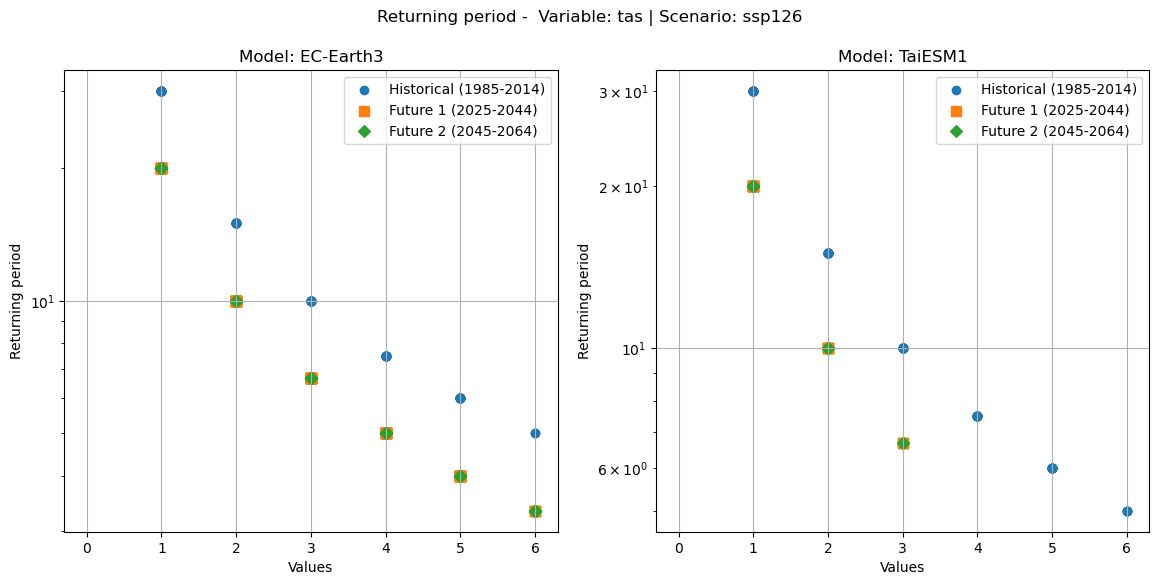

In [90]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp126'

returning_periods_2(variable=variables, model_names=models, scenarios=scenario)

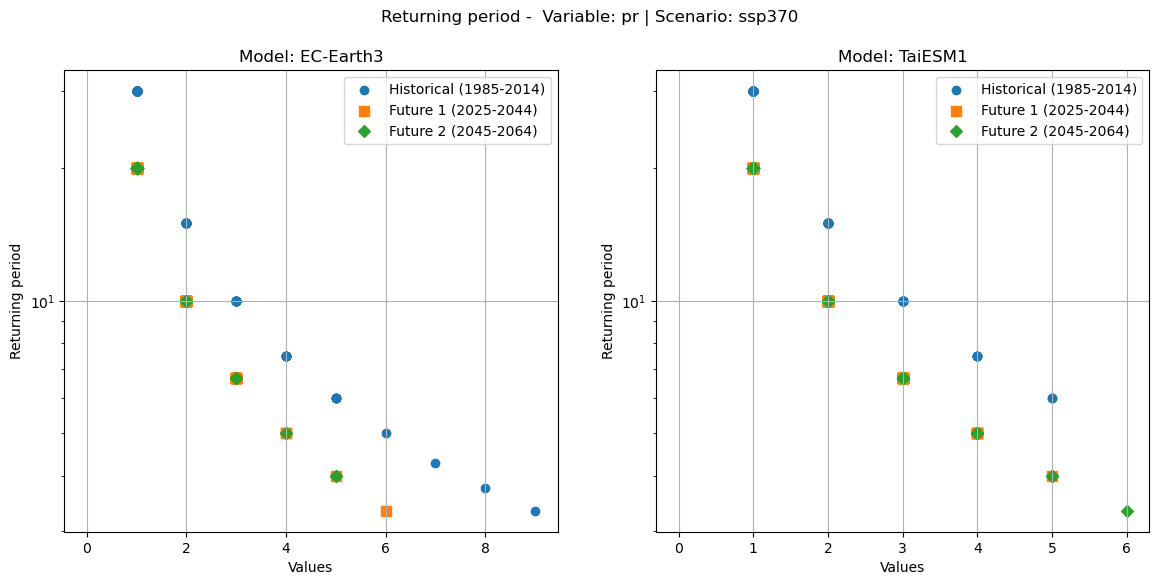

In [91]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp370'

returning_periods_2(variable=variables, model_names=models, scenarios=scenario)

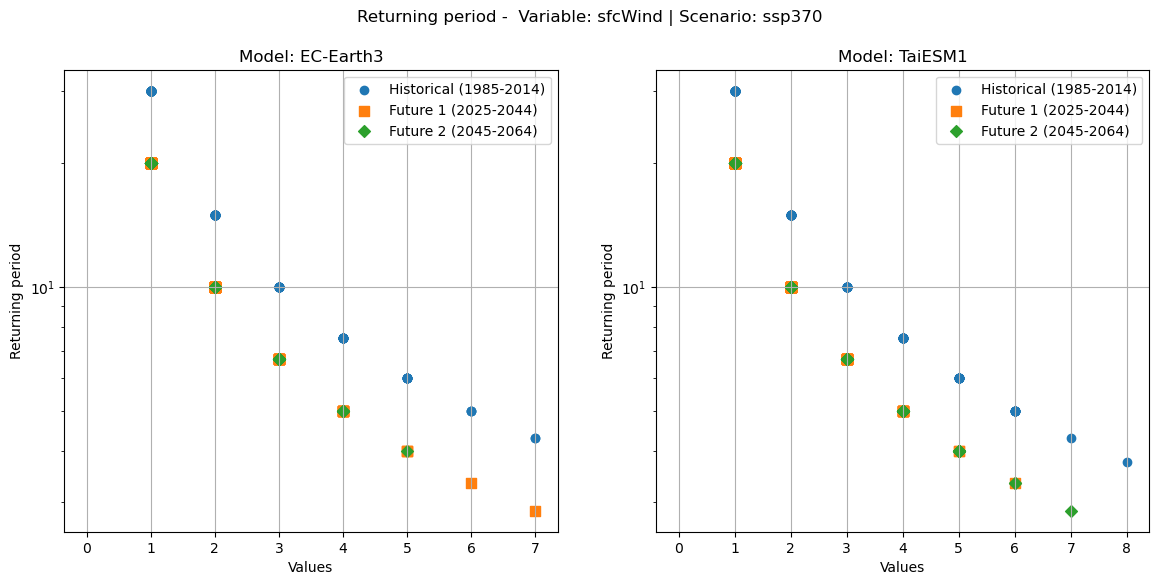

In [92]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp370'

returning_periods_2(variable=variables, model_names=models, scenarios=scenario)

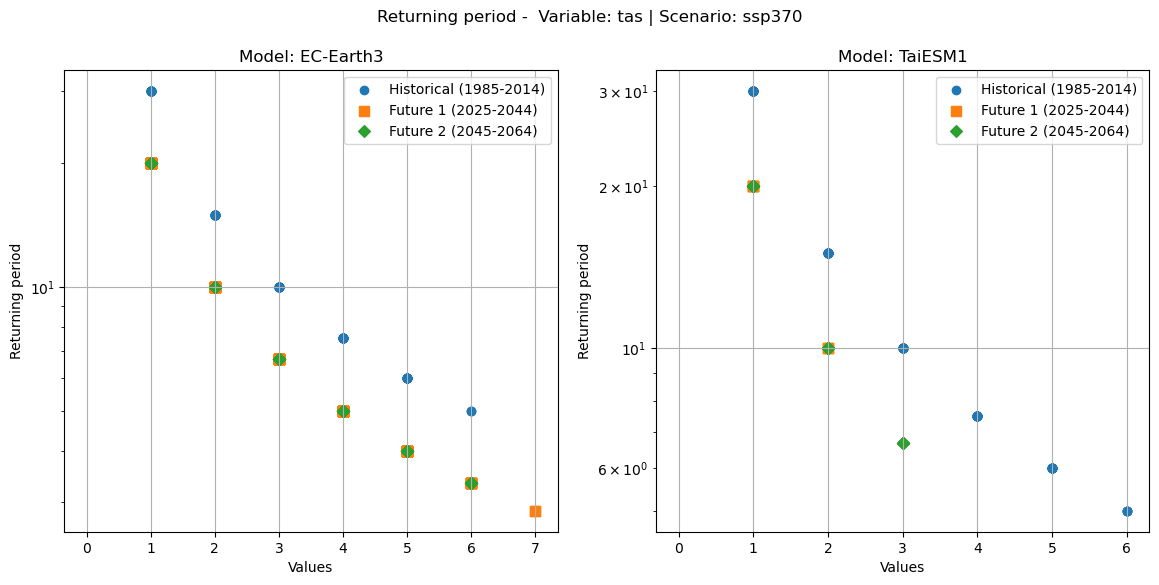

In [93]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp370'

returning_periods_2(variable=variables, model_names=models, scenarios=scenario)